In [1]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt

from noisifier import Noisifier
from splitter import Splitter
from dataset_preprocessor import PolarSpectrogramExtractor, AudioDatasetFromCSV

# Constants

Constants were set for use across all of the preprocessing scripts. AUDIO_DIR, HARM_NOISE_DIR, and ENV_NOISE_DIR already exist and contain audio sources, the corresponsig SAVE_DIRs are created by the preprocessor objects.

In [2]:
SAMPLE_RATE = 22050
SAMPLE_LENGTH = 2**16
FRAME_SIZE = 1024
HOP_LENGTH = 256
VALIDATION_SIZE = 0.1
BATCH_SIZE = 32
AUDIO_DIR = "./audio/guitar_samples/"
HARM_NOISE_DIR = "./audio/harm_noise/"
ENV_NOISE_DIR = "./audio/esc_50/"
TARGET_SAVE_DIR = "./audio/target/"
NOISE_SAVE_DIR = "./audio/noise/"
MIXED_SAVE_DIR = "./audio/mixed/"

# Instantiate Splitter
Code for the custom Splitter class can be found in the [splitter module](./splitter.py). The splitter is set to a given sample rate and target duration and splits audio files accoridingly. To ensure that all audio samples are the same size, the splitter will apply padding to the right size of a slice if the remaining audio in a given sample is shorter than the target duration. If the remaining audio is less than half of the target duration, the splitter will discard that slice. 

In [3]:
splitter_params = {
    'target_sr': SAMPLE_RATE,
    'target_length': SAMPLE_LENGTH
}

splitter = Splitter(**splitter_params)

# Split Target and Noise Files
If the given save directories do not yet exist, the splitter will create them before storing the split audio.

In [4]:
splitter.process_audio_files(directory=AUDIO_DIR, save_dir=TARGET_SAVE_DIR)
splitter.process_audio_files(directory=HARM_NOISE_DIR, save_dir=NOISE_SAVE_DIR)
splitter.process_audio_files(directory=ENV_NOISE_DIR, save_dir=NOISE_SAVE_DIR)


        2642 2.972154195011338-second audio files created in:
        ./audio/target/
        

        2612 2.972154195011338-second audio files created in:
        ./audio/noise/
        

        5012 2.972154195011338-second audio files created in:
        ./audio/noise/
        


# Instantiate Noisifier
The Noisifier object adds a target and noise audio signal together at a random signal to noise ratio. The code for this class can be viewed in the [noisifier module](./noisifier.py). The noisifier will create the save directory if it does not already exist.

In [4]:
noisifier_params = {
    'audio_dir': TARGET_SAVE_DIR, 
    'noise_dir': NOISE_SAVE_DIR, 
    'save_dir': MIXED_SAVE_DIR, 
    'sr': SAMPLE_RATE,
    'snr_range': [0, 5]
}

noisifier = Noisifier(**noisifier_params)

# Add Noise to Target Files
The noisifier saves both the mixed audio files and a csv with metadata about which audio signals were mixed together at what signal to noise ratio.

In [6]:
noisifier.noisify()

Please specify a name for the metadata csv file noise_metadata


Metadata saved at location: ./audio/noise_metadata.csv


# Instantiate Polar Spectrogram Extractor
The polar spectrogram extractor is part of the [dataset preprocessor module](./dataset_preprocessor.py). It works in tandem with the AudioDatasetFromCSV object to create a dataset of spectrograms based on the csv file produced by the noisifier.

In [5]:
extractor_params = {
    'frame_size': FRAME_SIZE,
    'hop_length': HOP_LENGTH
}
extractor = PolarSpectrogramExtractor(**extractor_params)

# Instantiate Custom Dataset Object
The dataset creator works with the spectrogram extractor to create a dataset with spectrograms of the mixed signals, original clean signals, and noise signals along with an expanded metadata csv to document the mixtures and their respective spectrogram and audio file paths. Once the dataset has been created once, the "prepared" attribute can be set to false and the metadata csv can be updated to the one produced by the dataset at the initial dataset creation. 

In [12]:
dataset_params = {
    'spectrogram_extractor': extractor,
    'metadata_csv': './audio/noise_metadata.csv',
    'validation_size': VALIDATION_SIZE,
    'sr': SAMPLE_RATE,
    'prepared': False
}

data = AudioDatasetFromCSV(**dataset_params)

# Preprocess Data

In [13]:
data.prepare_dataset()

# Make Train and Test Sets
This dataset object not only takes care of preprocessing, but also creates a spit train and testing set according to the validation size specified when instantiated. All of the train and test sets included in the object are created as numpy arrays with dimensions that are friendly to working with the tensorflow keras api.

In [14]:
data.train_test_split()

In [15]:
data.x_train.shape

(2377, 512, 256, 2)

In [531]:
# 30 146 35 96 128 122 26 44 227 205 96 111 79

128
./audio/noise/acoustic_performance_split_4.wav
Noisy Audio


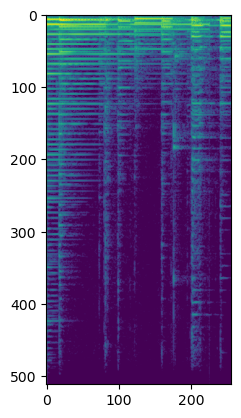

Original Audio


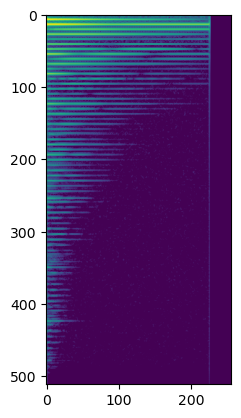

Denoised Audio


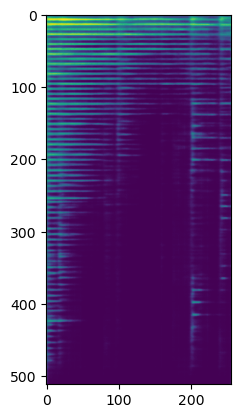

In [553]:
i = 128 #np.random.randint(low=0, high=len(data.x_test))
print(i)

recon_phi = recon_phis[i][...,0]
orig_phi = data.y_test[i][...,1]
mixed_phi = data.x_test[i][...,1]


recon_phase_spec = np.stack([reconstructed_specs[i], recon_phi], axis=-1)
orig_phase_spec = np.stack([reconstructed_specs[i], orig_phi], axis=-1)
mixed_phase_spec = np.stack([reconstructed_specs[i], mixed_phi], axis=-1)

minval, maxval = get_minmax_vals(data, i)

orig_audio = extractor.recover_signal(data.y_test[i], minval, maxval)
mixed_audio = extractor.recover_signal(data.x_test[i], minval, maxval)
orig_phase_signal = extractor.recover_signal(orig_phase_spec, minval, maxval)
mixed_phase_signal = extractor.recover_signal(mixed_phase_spec, minval, maxval)
print("Noisy Audio")
plt.imshow(data.x_test[i][...,0])
plt.show()
display_audio(mixed_audio)
print("Original Audio")
plt.imshow(data.y_test[i][...,0])
plt.show()
display_audio(orig_audio)
print("Denoised Audio")
plt.imshow(reconstructed_specs[i])
plt.show()
display_audio(orig_phase_signal)
display_audio(mixed_phase_signal)